# Map of Employment by sector and departement

In [1]:
from pynsee.localdata import *
from pynsee.geodata import *
from pynsee.metadata import *
from shapely import wkt

import math
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
import seaborn as sns

# get a list all data available : datasets and variables
metadata = get_local_metadata()

# geographic metadata
nivgeo = get_nivgeo_list()

!!! This function renders only package's internal data, it might not be the most up-to-date
Have a look at api.insee.fr !!!
!!! This function renders only package's internal data,
it might not be the most up-to-date
Have a look at api.insee.fr !!!


In [2]:
# get departement map
dep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')
dep = dep[["insee_dep", "geometry"]]
# remove overseas departments
dep = dep[~dep['insee_dep'].isin(['971', '972', '973', '974', '976'])]
dep = dep.rename(columns={'insee_dep': 'CODEGEO'})

Previously saved data used
/home/jovyan/.cache/pynsee/pynsee/a28d68dc88fcd55fe62626ea25a1760a.csv
Set update=True to get the most up-to-date data


In [3]:
data = get_local_data(dataset_version = 'GEO2020FLORES2017',
                     variables =  'NA17',
                     nivgeo = 'DEP')
data = data.rename(columns={'NA17': 'A17'})

Getting departements: 100%|██████████| 18/18 [00:32<00:00,  1.82s/it]


By default, the query is on all departements


Getting data:  10%|▉         | 10/102 [00:01<00:16,  5.70it/s]


API query number limit reached - function might be slowed down


Getting data: 100%|██████████| 102/102 [03:34<00:00,  2.10s/it]


!!! The underlying API is still at an early development stage,
future changes are likely !!!


In [4]:
# keep only headcounts and remove the total from the data
df = data[data["UNIT"] == "NBSALET"].reset_index(drop=True)
df = df[~df["A17"].isin(["ENS", "OQ"])].reset_index(drop=True)

In [5]:
# compute share of activity in total employment by department
df['employment_share'] = 100 * df["OBS_VALUE"] / df['OBS_VALUE'].groupby(df['CODEGEO']).transform('sum')

In [6]:
# merge values and geographic limits
datamap = dep.merge(df, how = 'left', on = 'CODEGEO')
datamap = gpd.GeoDataFrame(datamap).set_crs("EPSG:4326")

In [7]:
# add english activity labels at A17 level
activity = get_activity_list("A17")
activity["TITLE_A17_EN"] = activity["A17"] + " - " + activity["TITLE_A17_EN"]
datamap = datamap.merge(activity, how='left', on='A17')
activity

,A10,A17,TITLE_A17_EN,TITLE_A17_FR
0,AZ,AZ,"AZ - Agriculture, forestry and fishing","Agriculture, sylviculture et pêche"
1,BE,DE,"DE - Mining and quarrying; energy, water suppl...","Industries extractives, énergie, eau, gestion..."
2,BE,C1,"C1 - Manufacture of food products, beverages a...","Fabrication de denrées alimentaires, de boisso..."
3,BE,C5,C5 - Other manufacturing,Fabrication d'autres produits industriels
4,BE,C2,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage
5,BE,C3,"C3 - Manufacture of electrical, computer and e...","Fabrication d'équipements électriques, électro..."
6,BE,C4,C4 - Manufacture of transport equipment,Fabrication de matériels de transport
7,FZ,FZ,FZ - Construction,Construction
8,GI,GZ,GZ - Wholesale and retail trade; repair of mot...,Commerce ; réparation d'automobiles et de moto...
9,GI,HZ,HZ - Transportation and storage,Transports et entreposage


In [11]:
# compute center location for each departement
def get_center(x):
    return x.centroid.wkt
datamap["center"] = datamap['geometry'].apply(lambda x: get_center(x))

# list of departements
list_dep = datamap["CODEGEO"].unique() 

In [12]:
# make color palette
colors = sns.color_palette("Set1") + sns.color_palette("Set2")

# order activity sectors according to average share
emplTot = datamap[["employment_share", "TITLE_A17_EN"]].groupby(datamap['TITLE_A17_EN']).mean()
emplTot = emplTot.sort_values(by=["employment_share"],  ascending=False)

datamap["TITLE_A17_EN"] = datamap["TITLE_A17_EN"].astype(CategoricalDtype(categories=emplTot.index, ordered=True))
datamap = datamap.sort_values(["TITLE_A17_EN"])


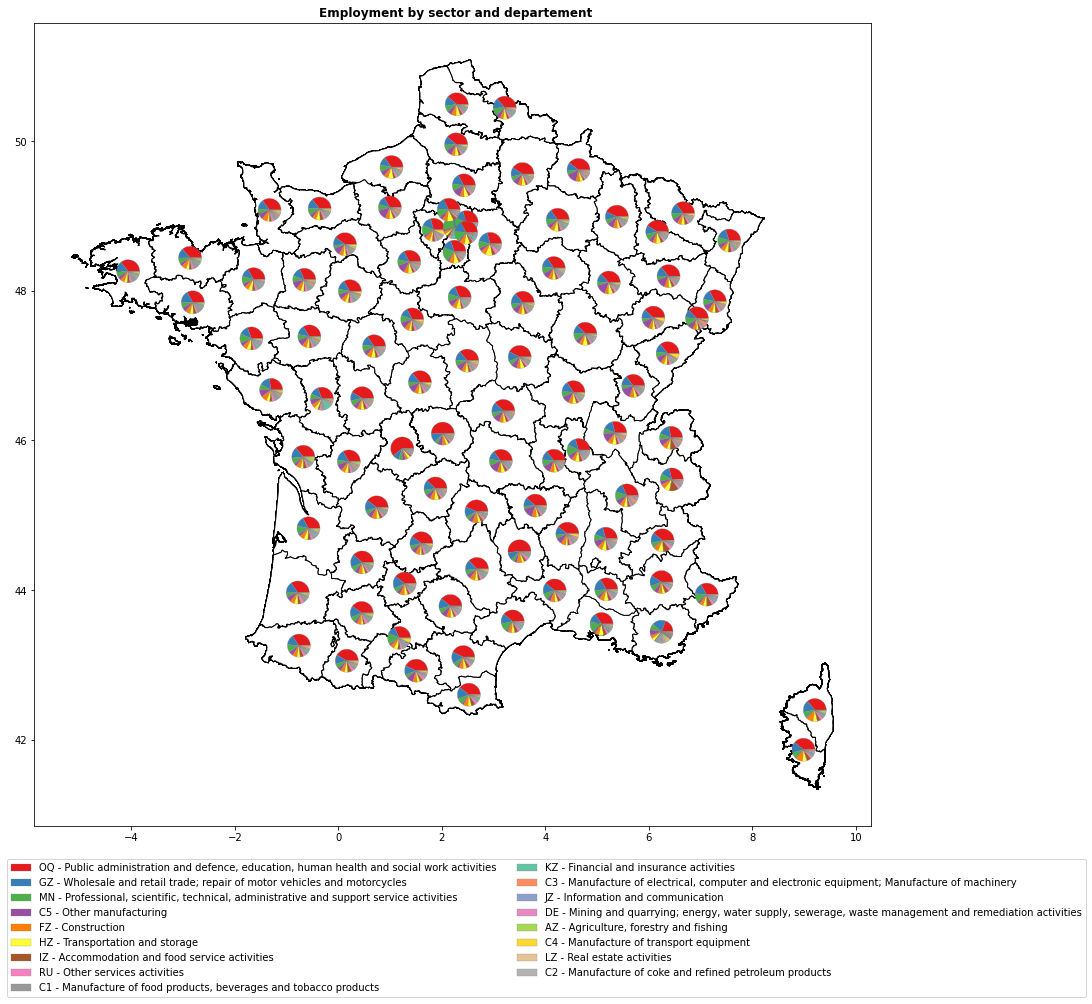

In [25]:
#draw plot

from matplotlib.pyplot import pie
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ax = datamap.plot(color='white', edgecolor='black', figsize = (15,15))

for idep in list_dep:
    df = datamap[datamap["CODEGEO"] == idep].reset_index(drop=True)
    ratios = df["employment_share"]
    Y, X = wkt.loads(df.loc[0, "center"]).xy
    lon, lat = Y[0], X[0]
    ax_sub = inset_axes(ax, width=0.4, height=0.4, loc=10, bbox_to_anchor=(lon, lat), bbox_transform=ax.transData)
    ax_sub.pie(ratios, wedgeprops={'edgecolor': 'gray','linewidth': 0.25}, colors = colors)
    
plt.legend(emplTot.index, loc='lower left', bbox_to_anchor=(-15, -27), ncol=2)
plt.title("Employment by sector and departement", x = -4, y = 7,
             horizontalalignment= 'left',
             fontsize = 12, fontweight='bold')
plt.show()

